In [2]:
import numpy as np
import pandas as pd
import random
from rdkit import Chem
from rdkit.Chem import Descriptors
# Source - https://stackoverflow.com/a
# Posted by erptocoding, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-04, License - CC BY-SA 4.0
df = pd.read_csv ("../data/raw_data/mtbs_tropical_annotations.tsv", sep = '\t')

#compounds sorted and unique based on smiles, rename some of the cols
compounds = df.rename(columns={'structure_smiles':'smiles', "structure_taxonomy_npclassifier_01pathway":"class","structure_taxonomy_npclassifier_03class": "my_class"}).groupby('smiles',                    
  sort=False).agg(lambda s: s.dropna().mode().iat[0] if not s.dropna().mode().empty else             
  np.nan).reset_index()

compounds.head()



,smiles,feature_id,component_id,libname,structure_inchikey,structure_molecular_formula,class,structure_taxonomy_npclassifier_02superclass,my_class
0,OC1OC[C@H](O)[C@H](O)[C@H]1O,64000,2173,MS1_match,SRBFZHDQGSBBOR-HWQSCIPKSA-N,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
1,O=C[C@@H](O)[C@H](O)[C@H](O)CO,64000,2173,MS1_match,PYMYPHUHKUWMLA-WDCZJNDASA-N,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
2,CCCCCCCCCCCCCCCCCCO,63994,2138,MS1_match,GLDOVTGHNKAZLK-UHFFFAOYSA-N,C18H38O,Fatty acids,Fatty acyls,Fatty alcohols
3,CC(C)=CCCC(C)=CCC1(CC=C(C)C)C(=O)C(O)=Cc2oc3cc...,63993,47,ISDB,FZFFGBOPCQADGY-UHFFFAOYSA-N,C28H32O6,Shikimates and Phenylpropanoids,Xanthones,Plant xanthones
4,C=C1C2=Nc3ccccc3[C@@]23CCN2C/C(=C/C)[C@H]1C[C@...,49491,126,MS1_match,KFXIUXCXSKTCNK-KLGAAMDDSA-N,C19H20N2,Terpenoids,Diterpenoids,Valparane diterpenoids


In [3]:
#generate fake presAbs data for testing purposes (would normally be generated by previous pipeline)
# initialize matrix of zeros
samples = ["sample1","sample2","sample3","sample4","sample5"]

presAbs = pd.DataFrame(0, index=samples, columns=compounds["structure_inchikey"])
for s in samples:
    for cmpd in compounds["structure_inchikey"]:
            presAbs.loc[s, cmpd] = random.randint(0,1) #0 symbolizes absence, 1 presence
mtbs = {"compounds":compounds, "presAbs":presAbs}
print(presAbs.transpose().describe())
print(compounds.describe())

            sample1       sample2       sample3       sample4       sample5
count  24046.000000  24046.000000  24046.000000  24046.000000  24046.000000
mean       0.500957      0.495342      0.498711      0.498087      0.499335
std        0.500009      0.499989      0.500009      0.500007      0.500010
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        1.000000      0.000000      0.000000      0.000000      0.000000
75%        1.000000      1.000000      1.000000      1.000000      1.000000
max        1.000000      1.000000      1.000000      1.000000      1.000000
         feature_id  component_id
count  24046.000000  24046.000000
mean   26625.848540   2607.263412
std    18592.817241   2958.811890
min        5.000000     -1.000000
25%     9669.250000    417.000000
50%    23879.000000   1473.000000
75%    42643.500000   3788.750000
max    64000.000000  14487.000000


In [4]:
def take_most_common(s: pd.Series):
    # same idea as R::which.max(table(x))
    counts = s.value_counts(dropna=False)
    return counts.idxmax()

#def derive_chemistry(mtbs):# Am schluss folgenden code noch einpacken in function
isPresent = mtbs["compounds"]['smiles'].notna() & (mtbs["compounds"]['smiles'] != "")
compoundsOK = mtbs["compounds"].loc[isPresent]  

# we want all columns from 'class' to 'my_class' (inclusive)
cols = list(compoundsOK.columns)
start = cols.index('class')
end = cols.index('my_class')
cols_to_agg = cols[start:end + 1]

compounds = (
    compoundsOK
    .groupby("smiles")[cols_to_agg]
    .agg(take_most_common)    # collapse each group to most common values
    .reset_index()            # `rownames_to_column("smiles")` analogue
)

#collapse metabolite data to smiles level
# select columns
met = mtbs["presAbs"].iloc[:, np.asarray(isPresent)]
# transpose and convert to DataFrame
met = met.T
# add smiles information
met["smiles"] = compoundsOK["smiles"].values
# group by smiles and take mean across all columns
metabolites = (met.groupby("smiles", as_index=False).mean())

display(metabolites)

## Prepare data tables
# select smiles column only
compReady = metabolites[["smiles"]]
# left join to compounds
compReady = compReady.merge(compounds, on="smiles", how="left")

# generate SID (=compound IDs)
compReady["SID"] = ["S" + str(i) for i in range(1, len(compReady) + 1)]
# reorder columns
cols = ["SID", "smiles"] + list(compounds.columns[compounds.columns.get_loc("class"):compounds.columns.get_loc("my_class") + 1])
compReady = compReady[cols]

mtbsReady = metabolites.drop(columns=["smiles"]).transpose()
mtbsReady.columns = compReady["SID"].values
mtbsReady[mtbsReady > 0] = 1


## Derive chemistry
smilesOnly = compReady.set_index("SID")["smiles"].to_dict()
smilesParsed = {sid: Chem.MolFromSmiles(sm) for sid, sm in smilesOnly.items()}

#redundant = [2, 7, 8, 11, 15, 17, 18, 20, 21, 24, 29] + list(range(33, 39)) + [41] + list(range(43, 46))
redundant = []
all_desc = [d[0] for d in Descriptors.descList]
descriptors = [d for i, d in enumerate(all_desc) if i not in redundant]










,smiles,sample1,sample2,sample3,sample4,sample5
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,0.0,1.0,0.0,1.0,1.0
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,0.0,1.0,0.0,1.0,0.0
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,0.0,0.0,0.0,0.0,0.0
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,1.0,0.0,0.0,1.0,1.0
4,C#CC#CC=CC=CC=CCCO,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...
24041,c1ccc2c(c1)oc1ccccc12,0.0,1.0,1.0,1.0,0.0
24042,c1ccc2c3c([nH]c2c1)[C@@H]1CCN2CCC[C@@H]2N1CC3,0.0,1.0,0.0,1.0,0.0
24043,c1cncc(-c2ncc(-c3ccc4c(c3)OCO4)o2)c1,1.0,1.0,1.0,1.0,0.0
24044,c1cncc(C2=NCCC2)c1,0.0,0.0,0.0,1.0,1.0


In [5]:
rawChem = ({
    sid: {name: Descriptors.__dict__[name](mol) for name in descriptors}
    for sid, mol in smilesParsed.items()
})

rawChem_df = pd.DataFrame.from_dict(rawChem, orient="index").reset_index().rename(columns={"index": "SID"})


In [6]:
display(rawChem_df)
compOut = (
    compReady
    .merge(rawChem_df, on = "SID", how="left")
)
compOut = compOut[["SID"] + list(compOut.loc[:, "smiles":"my_class"].columns) + list(compOut.loc["MaxAbsEStateIndex":"fr_urea"].columns)]
compOut.index = compOut["SID"]

display(compOut)

,SID,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,S1,5.138392,5.138392,0.937871,0.937871,0.332032,10.636364,292.466,264.242,292.219101,...,0,0,0,2,0,0,0,0,8,0
1,S2,5.223961,5.223961,0.943318,0.943318,0.309396,9.809524,282.471,252.231,282.234751,...,0,0,0,2,0,0,0,0,11,0
2,S3,8.490439,8.490439,0.043231,-0.043231,0.492037,9.043478,308.465,280.241,308.214016,...,0,0,0,1,0,0,0,0,8,0
3,S4,11.886906,11.886906,0.190474,0.190474,0.285907,14.772727,297.442,270.226,297.209264,...,0,0,0,1,0,0,0,0,4,0
4,S5,8.439692,8.439692,0.188318,0.188318,0.504961,10.461538,172.227,160.131,172.088815,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24041,S24042,5.652407,5.652407,0.961759,0.961759,0.499635,11.076923,168.195,160.131,168.057515,...,0,0,0,0,0,0,0,0,0,0
24042,S24043,3.734937,3.734937,0.630093,0.630093,0.792653,30.200000,267.376,246.208,267.173548,...,0,0,0,0,0,0,0,0,0,0
24043,S24044,5.768039,5.768039,0.260046,0.260046,0.712822,12.600000,266.256,256.176,266.069142,...,0,0,0,0,0,0,0,0,0,0
24044,S24045,4.382593,4.382593,0.990305,0.990305,0.591190,16.545455,146.193,136.113,146.084398,...,0,0,0,0,0,0,0,0,0,0


,SID,smiles,class,structure_taxonomy_npclassifier_02superclass,my_class,SID,smiles,class,structure_taxonomy_npclassifier_02superclass,my_class,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
"(S1, S1)",S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,...,0,0,0,2,0,0,0,0,8,0
"(S2, S2)",S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,...,0,0,0,2,0,0,0,0,11,0
"(S3, S3)",S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,...,0,0,0,1,0,0,0,0,8,0
"(S4, S4)",S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,...,0,0,0,1,0,0,0,0,4,0
"(S5, S5)",S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(S24042, S24042)",S24042,c1ccc2c(c1)oc1ccccc12,Shikimates and Phenylpropanoids,Coumarins,Simple coumarins,S24042,c1ccc2c(c1)oc1ccccc12,Shikimates and Phenylpropanoids,Coumarins,Simple coumarins,...,0,0,0,0,0,0,0,0,0,0
"(S24043, S24043)",S24043,c1ccc2c3c([nH]c2c1)[C@@H]1CCN2CCC[C@@H]2N1CC3,Alkaloids,Tryptophan alkaloids,Carboline alkaloids,S24043,c1ccc2c3c([nH]c2c1)[C@@H]1CCN2CCC[C@@H]2N1CC3,Alkaloids,Tryptophan alkaloids,Carboline alkaloids,...,0,0,0,0,0,0,0,0,0,0
"(S24044, S24044)",S24044,c1cncc(-c2ncc(-c3ccc4c(c3)OCO4)o2)c1,Alkaloids,Tyrosine alkaloids|Nicotinic acid alkaloids,Oxazole alkaloids|Pyridine alkaloids,S24044,c1cncc(-c2ncc(-c3ccc4c(c3)OCO4)o2)c1,Alkaloids,Tyrosine alkaloids|Nicotinic acid alkaloids,Oxazole alkaloids|Pyridine alkaloids,...,0,0,0,0,0,0,0,0,0,0
"(S24045, S24045)",S24045,c1cncc(C2=NCCC2)c1,Alkaloids,Nicotinic acid alkaloids,Pyridine alkaloids,S24045,c1cncc(C2=NCCC2)c1,Alkaloids,Nicotinic acid alkaloids,Pyridine alkaloids,...,0,0,0,0,0,0,0,0,0,0


In [7]:
def populate_chemistry(
    mtbs: pd.DataFrame,
    trait: pd.Series,
    missing_to_na: bool = True,
) -> pd.Series:
    # Populate per-species chemistry by averaging traits over present compounds, mirroring the R helper.
    trait_series = pd.Series(trait).reindex(mtbs.columns)
    values = []

    for _, row in mtbs.iterrows():
        present = row == 1
        if present.any():
            vals = trait_series[present].dropna()
            if vals.empty:
                values.append(np.nan if missing_to_na else 0)
                continue
            values.append(vals.mean())
        else:
            values.append(np.nan if missing_to_na else 0)

    return pd.Series(values, index=mtbs.index)

In [8]:
## Populate chemistry across presence-absence matrix ----

chemSpecies = pd.DataFrame({
    col: populate_chemistry(mtbsReady, compOut[col])
    for col in compOut.loc[:, "MaxAbsEStateIndex":"fr_urea"].columns
})

display(chemSpecies)
#delete species where all absent (shouldnt exist)
chemSpecies = chemSpecies.loc[:, chemSpecies.sum(axis=0) > 0]
display(mtbsReady)
display(compOut)
out = {"presAbs" :mtbsReady, "chemistry": chemSpecies, "compounds":compOut}
#return out

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
sample1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,...,S24037,S24038,S24039,S24040,S24041,S24042,S24043,S24044,S24045,S24046
sample1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
sample2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
sample3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
sample4,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
sample5,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,SID,smiles,class,structure_taxonomy_npclassifier_02superclass,my_class,SID,smiles,class,structure_taxonomy_npclassifier_02superclass,my_class,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
"(S1, S1)",S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,...,0,0,0,2,0,0,0,0,8,0
"(S2, S2)",S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,...,0,0,0,2,0,0,0,0,11,0
"(S3, S3)",S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,...,0,0,0,1,0,0,0,0,8,0
"(S4, S4)",S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,...,0,0,0,1,0,0,0,0,4,0
"(S5, S5)",S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(S24042, S24042)",S24042,c1ccc2c(c1)oc1ccccc12,Shikimates and Phenylpropanoids,Coumarins,Simple coumarins,S24042,c1ccc2c(c1)oc1ccccc12,Shikimates and Phenylpropanoids,Coumarins,Simple coumarins,...,0,0,0,0,0,0,0,0,0,0
"(S24043, S24043)",S24043,c1ccc2c3c([nH]c2c1)[C@@H]1CCN2CCC[C@@H]2N1CC3,Alkaloids,Tryptophan alkaloids,Carboline alkaloids,S24043,c1ccc2c3c([nH]c2c1)[C@@H]1CCN2CCC[C@@H]2N1CC3,Alkaloids,Tryptophan alkaloids,Carboline alkaloids,...,0,0,0,0,0,0,0,0,0,0
"(S24044, S24044)",S24044,c1cncc(-c2ncc(-c3ccc4c(c3)OCO4)o2)c1,Alkaloids,Tyrosine alkaloids|Nicotinic acid alkaloids,Oxazole alkaloids|Pyridine alkaloids,S24044,c1cncc(-c2ncc(-c3ccc4c(c3)OCO4)o2)c1,Alkaloids,Tyrosine alkaloids|Nicotinic acid alkaloids,Oxazole alkaloids|Pyridine alkaloids,...,0,0,0,0,0,0,0,0,0,0
"(S24045, S24045)",S24045,c1cncc(C2=NCCC2)c1,Alkaloids,Nicotinic acid alkaloids,Pyridine alkaloids,S24045,c1cncc(C2=NCCC2)c1,Alkaloids,Nicotinic acid alkaloids,Pyridine alkaloids,...,0,0,0,0,0,0,0,0,0,0


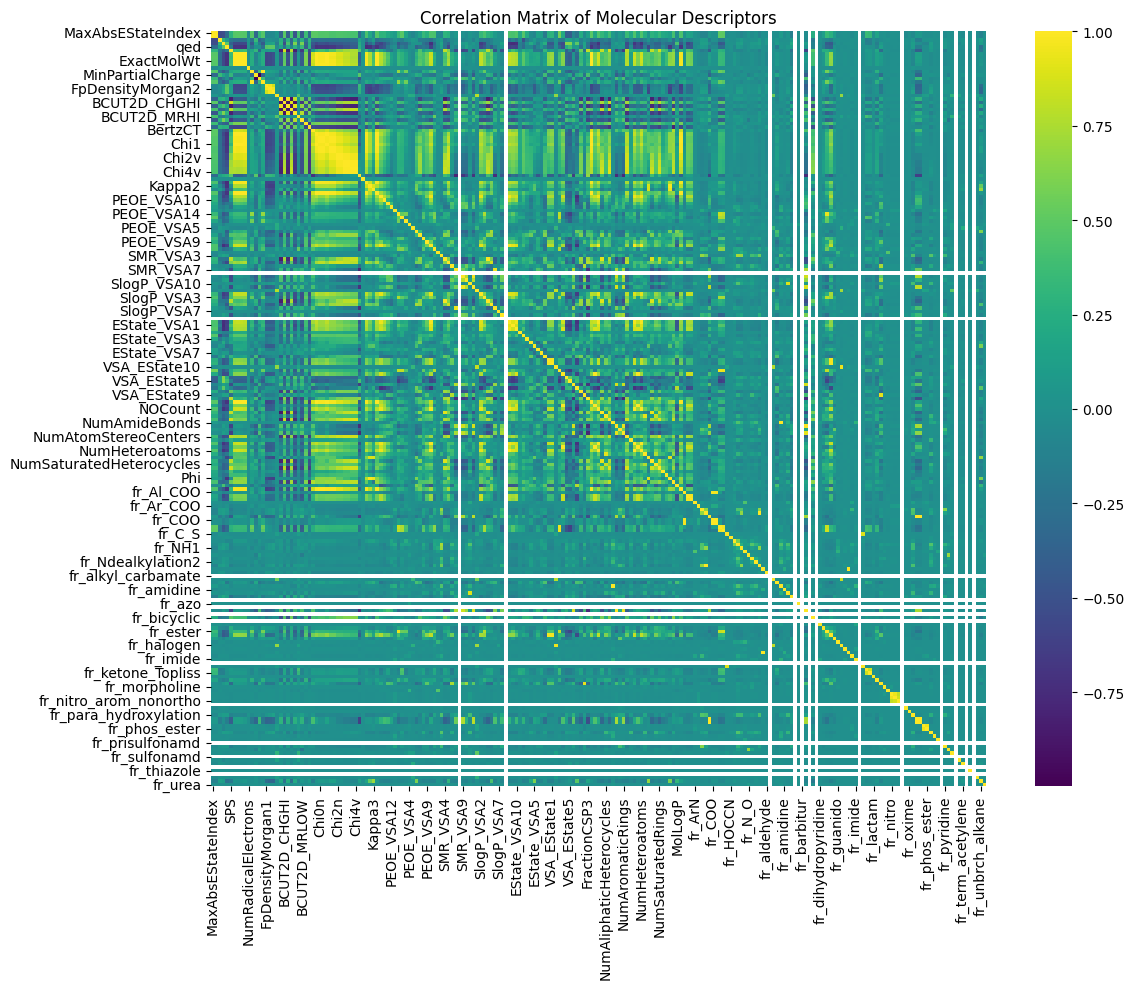

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = compOut

numeric_cols = df.select_dtypes(include=np.number).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="viridis", annot=False)
plt.title("Correlation Matrix of Molecular Descriptors")
plt.tight_layout()
plt.show()

c:\Users\dhess\Documents\UZH Courses\DSA 103 Advanced Chemical Data Science\DSA103_project\.venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

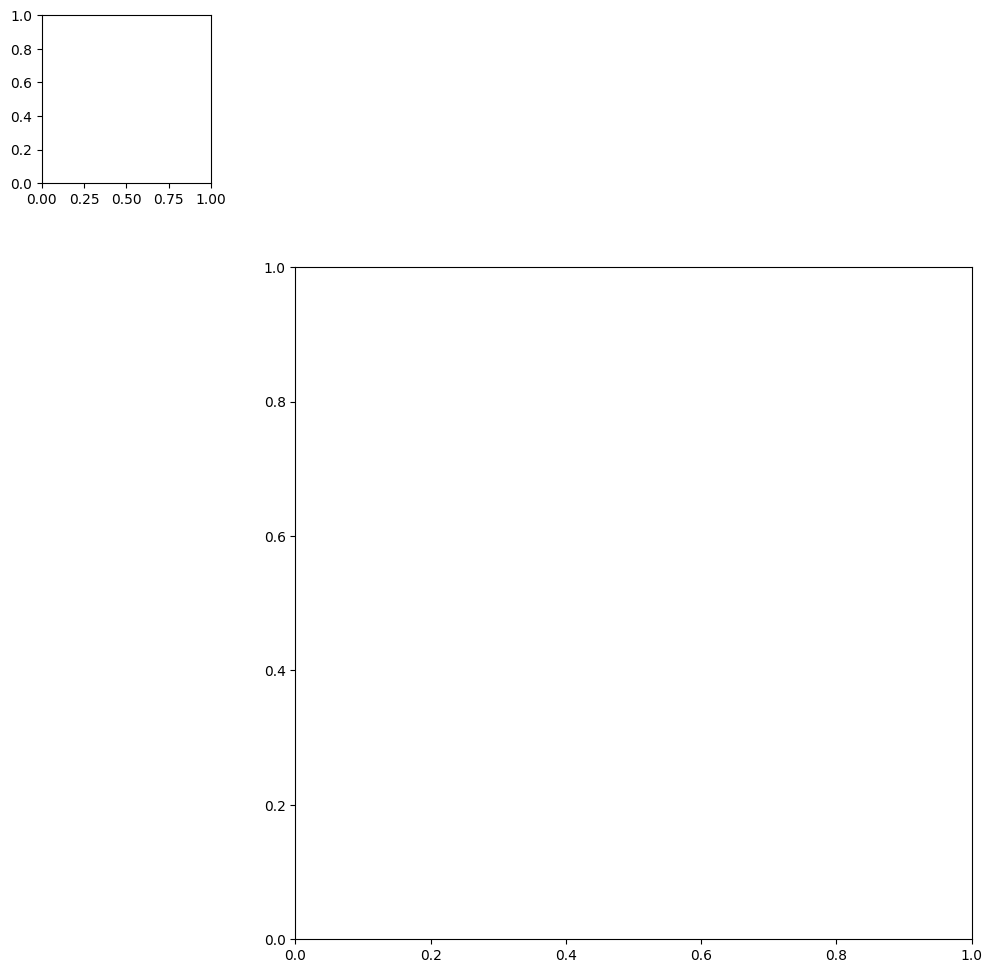

In [14]:
import seaborn as sns

# Select numeric descriptors and drop columns with no variance
numeric_df = df.select_dtypes(include=np.number)
numeric_df = numeric_df.loc[:, numeric_df.std() > 0]

if numeric_df.shape[1] < 2:
    print('Not enough numeric columns with variance for clustering.')
else:
    corr = numeric_df.corr()
    corr = corr.replace([np.inf, -np.inf], np.nan)
    corr = corr.dropna(axis=0, how='any').dropna(axis=1, how='any')

    if corr.empty or corr.shape[0] < 2 or corr.shape[1] < 2:
        print('Correlation matrix too small after cleaning.')
    else:
        try:
            sns.clustermap(
                corr,
                method="ward",      # clustering method
                metric="euclidean", # distance on the correlation rows
                cmap="viridis",
                linewidths=0.2,
                figsize=(12, 12)
            )
            plt.show()
        except ValueError as e:
            print(f'Clustermap failed: {e}')
